In [1]:
import sscv 
import mmcv 
import matplotlib.pyplot as plt 

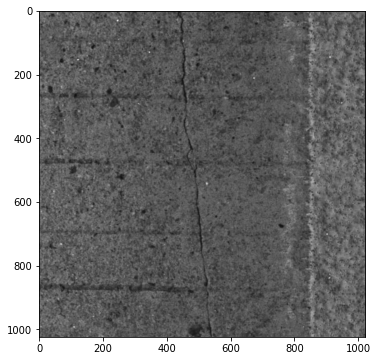

In [2]:
# Let's take a look at the dataset 

img = sscv.imread("/home/soojin/UOS-SSaS Dropbox/05. Data/02. Training&Test/bridge_road_crack/leftImg8bit/train/P-041-E1_s000202000__0,17408)__leftImg8bit.png")
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.show()

In [3]:
# We need to convert the annotation into semantic map format as an image 
import os.path as osp
import numpy as np 
from PIL import Image 

In [4]:
data_root = "/home/soojin/UOS-SSaS Dropbox/05. Data/02. Training&Test/bridge_road_crack/"
img_dir = 'leftImg8bit/train'
ann_dir = 'gtFine/train'

classes = ('crack', )

palette = [[128, 0, 0]]

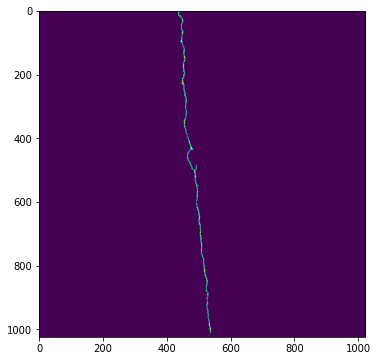

In [5]:
import matplotlib.patches as mpatches
img = Image.open(osp.join(data_root, ann_dir, 'P-041-E1_s000202000__0,17408)__gtFine_labelIds.png'))
plt.figure(figsize=(8, 6))
im = plt.imshow(img)


In [6]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

In [7]:
@DATASETS.register_module()
class ConcreteCrackCityScapes(CustomDataset):
    """Cityscapes dataset.

    The ``img_suffix`` is fixed to '_leftImg8bit.png' and ``seg_map_suffix`` is
    fixed to '_gtFine_labelTrainIds.png' for Cityscapes dataset.
    """

    CLASSES = ('background', 'crack')
    PALETTE = [[0, 0, 0], [255, 0, 0]]

    def __init__(self, **kwargs):
        super(ConcreteCrackCityScapes, self).__init__(
            img_suffix='_leftImg8bit.png',
            seg_map_suffix='_gtFine_labelIds.png',
            **kwargs)


In [8]:
from mmcv import Config
cfg = Config.fromfile("/home/soojin/mmsegmentation/configs/deeplabv3plus/deeplabv3plus_r101-d8_769x769_40k_cityscapes.py")

In [9]:
from mmseg.apis import set_random_seed


# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2


# Modify dataset type and path
cfg.dataset_type = 'ConcreteCrackCityScapes'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu = 2


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'


# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='DepthwiseSeparableASPPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        dilations=(1, 12, 24, 36),
        c1_in_channels=256,
        c1_channels=48,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=True,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_i

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/home/soojin/anaconda3/envs/auto-label/lib/python3.8/site-packages/mmcv/utils/misc.py:303: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  warnings.warn(
2021-04-16 16:16:58,312 - mmseg - INFO - Loaded 657 images
/home/soojin/anaconda3/envs/auto-label/lib/python3.8/site-packages/mmseg/models/builder.py:59: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(
2021-04-16 16:16:59,951 - mmseg - INFO - Use load_from_openmmlab loader
2021-04-16 16:17:00,126 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

/home/soojin/anaconda3/envs/auto-label/lib/python3.8/site-packages/mmseg/apis/train.py:76: UserWarning: config is now expected to have a `runner` section, please set `runner` in your config.
  warnings.warn(
2021-04-16 16:17:04,061 - mmseg - INFO - Loaded 657 images
2021-04-16 16:17:04,063 - mmseg - INFO - Start running,

2021-04-16 16:40:38,183 - mmseg - INFO - Iter [1550/40000]	lr: 9.654e-03, eta: 9:44:35, time: 0.911, data_time: 0.005, memory: 12325, decode.loss_seg: 0.0121, decode.acc_seg: 93.3630, aux.loss_seg: 0.0054, aux.acc_seg: 93.3607, loss: 0.0175
2021-04-16 16:41:23,707 - mmseg - INFO - Iter [1600/40000]	lr: 9.643e-03, eta: 9:43:47, time: 0.910, data_time: 0.005, memory: 12325, decode.loss_seg: 0.0106, decode.acc_seg: 96.6253, aux.loss_seg: 0.0047, aux.acc_seg: 96.6191, loss: 0.0153
2021-04-16 16:42:09,773 - mmseg - INFO - Iter [1650/40000]	lr: 9.632e-03, eta: 9:43:12, time: 0.921, data_time: 0.016, memory: 12325, decode.loss_seg: 0.0105, decode.acc_seg: 97.6680, aux.loss_seg: 0.0048, aux.acc_seg: 97.6596, loss: 0.0153
2021-04-16 16:42:55,247 - mmseg - INFO - Iter [1700/40000]	lr: 9.621e-03, eta: 9:42:23, time: 0.909, data_time: 0.005, memory: 12325, decode.loss_seg: 0.0116, decode.acc_seg: 93.3933, aux.loss_seg: 0.0052, aux.acc_seg: 93.3756, loss: 0.0168
2021-04-16 16:43:40,738 - mmseg - IN

2021-04-16 17:06:26,684 - mmseg - INFO - Iter [3250/40000]	lr: 9.273e-03, eta: 9:18:18, time: 0.909, data_time: 0.005, memory: 12325, decode.loss_seg: 0.0083, decode.acc_seg: 94.5772, aux.loss_seg: 0.0039, aux.acc_seg: 94.5549, loss: 0.0122
2021-04-16 17:07:12,728 - mmseg - INFO - Iter [3300/40000]	lr: 9.262e-03, eta: 9:17:38, time: 0.921, data_time: 0.017, memory: 12325, decode.loss_seg: 0.0096, decode.acc_seg: 96.7002, aux.loss_seg: 0.0045, aux.acc_seg: 96.6607, loss: 0.0142
2021-04-16 17:07:58,138 - mmseg - INFO - Iter [3350/40000]	lr: 9.251e-03, eta: 9:16:50, time: 0.908, data_time: 0.005, memory: 12325, decode.loss_seg: 0.0119, decode.acc_seg: 94.2074, aux.loss_seg: 0.0053, aux.acc_seg: 94.1706, loss: 0.0172
2021-04-16 17:08:43,572 - mmseg - INFO - Iter [3400/40000]	lr: 9.240e-03, eta: 9:16:03, time: 0.909, data_time: 0.005, memory: 12325, decode.loss_seg: 0.0084, decode.acc_seg: 96.9765, aux.loss_seg: 0.0040, aux.acc_seg: 96.9460, loss: 0.0124
2021-04-16 17:09:29,022 - mmseg - IN

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 657/657, 2.0 task/s, elapsed: 326s, ETA:     0s

2021-04-16 17:23:40,068 - mmseg - INFO - per class results:
2021-04-16 17:23:40,071 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 99.72 | 99.98 |
| crack      | 15.33 | 16.4  |
+------------+-------+-------+
2021-04-16 17:23:40,072 - mmseg - INFO - Summary:
2021-04-16 17:23:40,072 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 57.52 | 58.19 | 99.72 |
+--------+-------+-------+-------+
2021-04-16 17:23:40,082 - mmseg - INFO - Iter(val) [4000]	mIoU: 0.5752, mAcc: 0.5819, aAcc: 0.9972, IoU.background: 0.9972, IoU.crack: 0.1533, Acc.background: 0.9998, Acc.crack: 0.1640
2021-04-16 17:24:25,722 - mmseg - INFO - Iter [4050/40000]	lr: 9.093e-03, eta: 9:51:01, time: 7.897, data_time: 6.989, memory: 12325, decode.loss_seg: 0.0075, decode.acc_seg: 95.3068, aux.loss_seg: 0.0035, aux.acc_seg: 95.2649, loss: 0.0110
2021-04-16 17:25:11

2021-04-16 17:47:57,299 - mmseg - INFO - Iter [5600/40000]	lr: 8.744e-03, eta: 9:13:31, time: 0.921, data_time: 0.016, memory: 12325, decode.loss_seg: 0.0070, decode.acc_seg: 96.8448, aux.loss_seg: 0.0033, aux.acc_seg: 96.8042, loss: 0.0103
2021-04-16 17:48:42,980 - mmseg - INFO - Iter [5650/40000]	lr: 8.732e-03, eta: 9:12:27, time: 0.914, data_time: 0.006, memory: 12325, decode.loss_seg: 0.0104, decode.acc_seg: 94.3414, aux.loss_seg: 0.0047, aux.acc_seg: 94.2902, loss: 0.0151
2021-04-16 17:49:28,555 - mmseg - INFO - Iter [5700/40000]	lr: 8.721e-03, eta: 9:11:23, time: 0.911, data_time: 0.005, memory: 12325, decode.loss_seg: 0.0090, decode.acc_seg: 96.0430, aux.loss_seg: 0.0042, aux.acc_seg: 96.0082, loss: 0.0132
2021-04-16 17:50:14,186 - mmseg - INFO - Iter [5750/40000]	lr: 8.710e-03, eta: 9:10:19, time: 0.913, data_time: 0.006, memory: 12325, decode.loss_seg: 0.0084, decode.acc_seg: 95.5946, aux.loss_seg: 0.0040, aux.acc_seg: 95.5477, loss: 0.0124
2021-04-16 17:50:59,761 - mmseg - IN

2021-04-16 18:13:50,655 - mmseg - INFO - Iter [7300/40000]	lr: 8.358e-03, eta: 8:39:36, time: 0.912, data_time: 0.006, memory: 12325, decode.loss_seg: 0.0077, decode.acc_seg: 94.4883, aux.loss_seg: 0.0036, aux.acc_seg: 94.4482, loss: 0.0114
2021-04-16 18:14:36,306 - mmseg - INFO - Iter [7350/40000]	lr: 8.347e-03, eta: 8:38:40, time: 0.913, data_time: 0.006, memory: 12325, decode.loss_seg: 0.0090, decode.acc_seg: 96.1497, aux.loss_seg: 0.0042, aux.acc_seg: 96.0944, loss: 0.0132
2021-04-16 18:15:21,941 - mmseg - INFO - Iter [7400/40000]	lr: 8.335e-03, eta: 8:37:43, time: 0.913, data_time: 0.006, memory: 12325, decode.loss_seg: 0.0068, decode.acc_seg: 94.1283, aux.loss_seg: 0.0032, aux.acc_seg: 94.0908, loss: 0.0099
2021-04-16 18:16:07,552 - mmseg - INFO - Iter [7450/40000]	lr: 8.324e-03, eta: 8:36:46, time: 0.912, data_time: 0.005, memory: 12325, decode.loss_seg: 0.0065, decode.acc_seg: 95.6834, aux.loss_seg: 0.0032, aux.acc_seg: 95.6452, loss: 0.0097
2021-04-16 18:16:53,085 - mmseg - IN

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 657/657, 2.0 task/s, elapsed: 330s, ETA:     0s

2021-04-16 18:30:28,041 - mmseg - INFO - per class results:
2021-04-16 18:30:28,047 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 99.72 | 99.98 |
| crack      | 15.71 | 16.62 |
+------------+-------+-------+
2021-04-16 18:30:28,048 - mmseg - INFO - Summary:
2021-04-16 18:30:28,051 - mmseg - INFO - 
+--------+-------+------+-------+
| Scope  | mIoU  | mAcc | aAcc  |
+--------+-------+------+-------+
| global | 57.71 | 58.3 | 99.72 |
+--------+-------+------+-------+
2021-04-16 18:30:28,061 - mmseg - INFO - Iter(val) [8000]	mIoU: 0.5771, mAcc: 0.5830, aAcc: 0.9972, IoU.background: 0.9972, IoU.crack: 0.1571, Acc.background: 0.9998, Acc.crack: 0.1662
2021-04-16 18:31:16,294 - mmseg - INFO - Iter [8050/40000]	lr: 8.188e-03, eta: 8:46:28, time: 8.114, data_time: 7.155, memory: 12325, decode.loss_seg: 0.0080, decode.acc_seg: 95.8993, aux.loss_seg: 0.0037, aux.acc_seg: 95.8514, loss: 0.0117
